## Using a VLM for ocr

- "classic" ocr models like [tessseract](https://github.com/tesseract-ocr/tesseract) are tranined on "detection data" - e.g., individual object detections [like this dataset](https://huggingface.co/datasets/detection-datasets/coco) - and are likewise used to detect (fundamentally) characters first

- transformer / visual-language-models like [kosmos](https://github.com/microsoft/unilm/tree/master/kosmos-2.5) are trained not on indiviudal characters, but entire images.   typically the text contained in the image is treated as a target caption.

- some strengths vs a classic model
    - potentially fewer pre-processing steps need be performed
        - model itself may explicitly contain pre-processing steps like these, so they are performed at training / inference (particularly normalization steps) - always check how a model is trained to ensure
        - other steps like deskewing *may* be more easily overcome as well, as often each image in training is replicated in multiple ways (e.g., by rotating it through a range of angles) enlarge training data.  this potentially results in less of a need to deskew - always check how a model is trained to ensure
        - since vlms are often trained on image captions, we can extract more than just the text of an image - we can extract rich information about the content of the image itself

- some weaknesses:
    - accuracy is (currently) weak for moderately complex documents
    - not (yet) as well minituraized: to run fast you'll need decent hardware
    - sensitive to prompting: different prompts result in variant results
    - stochastic by nature: on inference llms are often inherently stochastic, meaning the same prompt can return different results
    - swiss army vs kitchen knife: often vlms are trained for various explicit purposes - e.g., image captioning, object detection, etc., - and so can easily become "jacks of all trades but masters of none" unless properly fine tuned
    - llms "halucinate": this can effect quality of both extracted text and content descriptions
    - resolution: currently vlm models are often trained on small-ish resolutions that can make picking up smaller text difficult (this will change)
    - sanity checking: because a vlm has multiple "moving parts" - an llm, encoder, decoder - not as easy to "sanity check" - e.g., by plotting detections and bounding boxes
    - of course: a model is only as good as its training / fine tuning data - so ideally you want to understand what data a model is trained on (e.g., [a popular example for ocr training](https://huggingface.co/datasets/naver-clova-ix/synthdog-en?row=0))

--- 

- below we will use the fantastic, tiny, and open source vlm [moondream](https://github.com/vikhyat/moondream) as our ocr model
- there are an array of larger models out there - including the original [donut](https://github.com/clovaai/donut) (one of the first published transformer approach to ocr in 2022) and [kosmos](https://github.com/microsoft/unilm/tree/master/kosmos-2.5)
- this model is pretty good at capturing the text in a simple images - like a meme - but struggles with moderately complex images of text

- we can basically think of prompt-engineering here as a bespoke pre-processing step when using vlms as ocr engines

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from PIL import Image
import transformers
transformers.logging.set_verbosity_error()


def prompt_moondream(img_path: str, prompt: str) -> str:
    # copied from moondream demo readme --> https://github.com/vikhyat/moondream/tree/main
    model_id = "vikhyatk/moondream2"
    revision = "2024-05-20"
    model = AutoModelForCausalLM.from_pretrained(
        model_id, trust_remote_code=True, revision=revision,
    )
    tokenizer = AutoTokenizer.from_pretrained(model_id, revision=revision)
    image = Image.open(img_path)
    enc_image = model.encode_image(image)
    moondream_response = model.answer_question(enc_image, prompt, tokenizer)
    return moondream_response

/Users/jeremywatt/Desktop/krixik/code/content-creation/meme_organizer/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# list of memes, first we visualize
img_paths = [
    "data/input/seal.jpg",
    "data/input/real_men.jpg"
]

prompt = "What does the text on this image say?  Return only the text you find."
answers = []
for img_path in img_paths:
    answer = prompt_moondream(img_path, prompt)
    answers.append(answer)

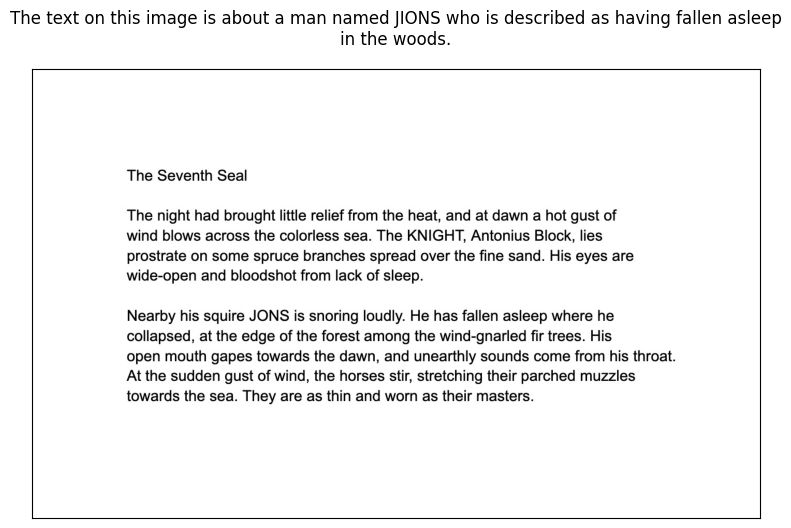

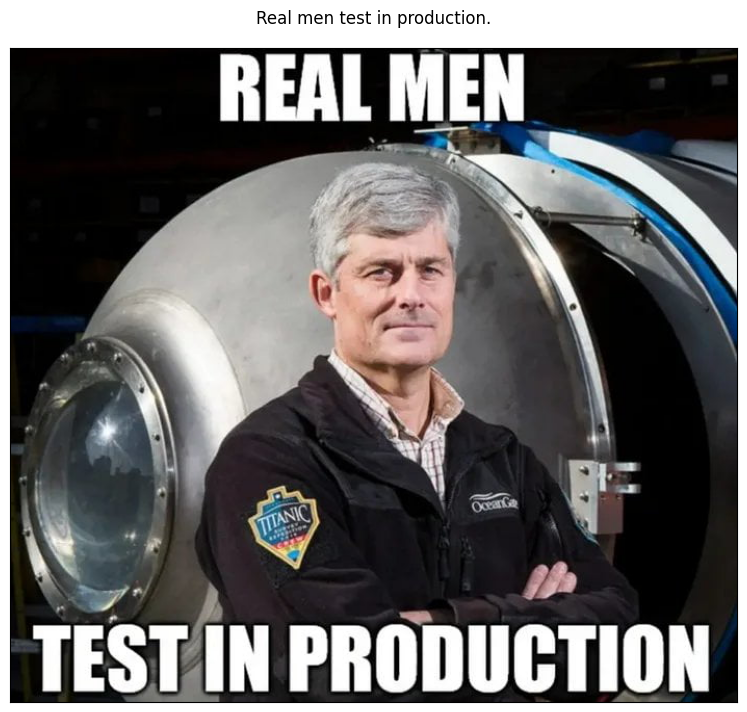

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

images = [Image.open(img_path) for img_path in img_paths]

for ind in range(len(images)):
    img = images[ind]
    ans = answers[ind]
    ans = '.\n'.join(ans.split('.'))
    fig, sub = plt.subplots(nrows=1, ncols=1, figsize=(8, 8));
    fig.tight_layout(); 

    sub.imshow(img)
    sub.set_xticks([]);
    sub.set_yticks([]);
    sub.set_title(ans, wrap=True, ha='center',va="top")


- while the first result does not give us the text on the page, it does provide an accurate summary of the text contained in the image
- perhaps improving our prompt might enable us better extraction in the first case
- the second result is spot on
- these models are - relative to the age of tesseract - relatively new, with one of the first major push [published only in 2022](https://github.com/clovaai/donut)